In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fftpack import fft, fftfreq
from scipy.interpolate import interp1d
from numpy import arange, amax, amin, asarray, zeros, cumsum,transpose,size

In [2]:
mpl.rcParams['font.size'] = 12

In [3]:
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, phase, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt

In [4]:
def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    '''
    Calculate a trapezoidal bandpass wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)
    
    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
    
    nsamp = int(wvlt_length/dt + 1)
    
    
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq*0.0
    pspec = freq*0.0
    
    # Calculate slope and y-int for low frequency ramp
    M1 = 1/(f2-f1)
    b1 = -M1*f1
    
    # Calculate slop and y-int for high frequency ramp
    M2 = -1/(f4-f3)
    b2 = -M2*f4
    
    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)
    
    # Build LF ramp
    idx = np.nonzero((np.abs(freq)>=f1) & (np.abs(freq)<f2))
    filt[idx] = M1*np.abs(freq)[idx]+b1
    
    # Build central filter flat
    idx = np.nonzero((np.abs(freq)>=f2) & (np.abs(freq)<=f3))
    filt[idx] = 1.0
    
    # Build HF ramp
    idx = np.nonzero((np.abs(freq)>f3) & (np.abs(freq)<=f4))
    filt[idx] = M2*np.abs(freq)[idx]+b2
    
    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2*np.exp(np.zeros(filt2.shape)*1j)
    
    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt/np.max(np.abs(wvlt)) # normalize wavelet by peak amplitude
    
    # Generate array of wavelet times
    t = np.linspace(-wvlt_length*0.5, wvlt_length*0.5, nsamp)
    
    
    # Apply phase rotation if desired
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt

In [5]:
def make_wedge(n_traces,encasing_thickness,min_thickness,max_thickness,dz=0.1):
    encasing_thickness *= (1.//dz)
    min_thickness *= (1.//dz)
    max_thickness *= (1.//dz)
    deltaz=float(max_thickness-min_thickness)/float(n_traces)
    n_samples=max_thickness+encasing_thickness*2
    wedge = np.zeros((int(n_samples), int(n_traces)))
    wedge[0:int(encasing_thickness),:]=1
    wedge[int(encasing_thickness):,:]=3
    wedge[int(encasing_thickness):int(encasing_thickness+min_thickness),:]=2
    for i in range(n_traces):
        wedge[int(encasing_thickness+min_thickness):int(encasing_thickness+min_thickness)+int(round(deltaz*i)),i]=2
    print( "wedge minimum thickness: %.2f m" % (min_thickness*dz))
    print( "wedge maximum thickness: %.2f m" % (max_thickness*dz))
    return wedge

In [6]:
def assign_ai(model, aiprop):
    model_ai=np.zeros(model.shape)
    code = 1
    for x in aiprop:
        model_ai[model==code] = x[0]*x[1]
        code += 1
    return model_ai

In [7]:
def assign_vel(model, aiprop):
    model_vel=np.zeros(model.shape)
    code=1
    for x in aiprop:
        model_vel[model==code] = x[0]
        code += 1
    return model_vel

In [8]:
def assign_el(model, elprop):
    model_vp=np.zeros(model.shape)
    model_vs=np.zeros(model.shape)
    model_rho=np.zeros(model.shape)
    code = 1
    for i in elprop:
        model_vp[model==code]  = i[0]
        model_vs[model==code]  = i[2]
        model_rho[model==code] = i[1]
        code += 1
    return model_vp,model_vs,model_rho

In [9]:
def make_rc(imp):

    rc=(imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])
    return rc

In [10]:
def make_rc_elastic(model_vp,model_vs,model_rho,ang):

    from agilegeo.avo import akirichards
    [n_samples, n_traces] = model_vp.shape
    rc_near=np.zeros((n_samples,n_traces))
    rc_mid=np.zeros((n_samples,n_traces))
    rc_far=np.zeros((n_samples,n_traces))
    uvp  = model_vp[:-1][:][:]
    lvp  = model_vp[1:][:][:]
    uvs  = model_vs[:-1][:][:]
    lvs  = model_vs[1:][:][:]
    urho = model_rho[:-1][:][:]
    lrho = model_rho[1:][:][:]
    rc_near=akirichards(uvp,uvs,urho,lvp,lvs,lrho,ang[0])
    rc_mid=akirichards(uvp,uvs,urho,lvp,lvs,lrho,ang[1])
    rc_far=akirichards(uvp,uvs,urho,lvp,lvs,lrho,ang[2])
    rc_near=np.concatenate((rc_near,np.zeros((1,n_traces))))    # add 1 row of zeros at the end
    rc_mid=np.concatenate((rc_mid,np.zeros((1,n_traces))))
    rc_far=np.concatenate((rc_far,np.zeros((1,n_traces))))
    return rc_near, rc_mid, rc_far

In [11]:
def make_synth(rc,wavelet):
    nt=np.size(wavelet)
    if rc.ndim>1:
        [n_samples, n_traces] = rc.shape
        synth = np.zeros((n_samples+nt-1, n_traces))
        for i in range(n_traces):
            synth[:,i] = np.convolve(rc[:,i], wavelet)
        synth = synth[int(np.ceil(len(wavelet))/2):int(-np.ceil(len(wavelet))/2), :]
        synth=np.concatenate((synth,np.zeros((1,n_traces))))
    else:
        n_samples = rc.size
        synth = np.zeros(n_samples+nt-1)
        synth = np.convolve(rc, wavelet)
        synth = synth[np.ceil(len(wavelet))/2:-np.ceil(len(wavelet))/2]
        synth=np.concatenate((synth,[0]))
    return synth

In [12]:
def forward_model(model,aiprop,wavelet,dz,dt):

    earth = assign_ai(model, aiprop)
    vels = assign_vel(model, aiprop)
    earth_time=depth_to_time(earth,vels,dz,dt,twt=True)
    rc = make_rc(earth_time)
    return make_synth(rc,wavelet)

In [13]:
def extract_amp(data,elprop,encasing_thickness,min_thickness,max_thickness,dt,freq):

    [ns,nt]=data.shape
    twt=np.arange(0,ns*dt,dt)

    Fd=freq*1.3
    b=1/Fd
    cerca=int((b/dt)/2)

    # if Ip_above<Ip_below then we have an INCREASE in Ip = positive RC = peak
    top_is_peak=elprop[0,0]*elprop[0,1]<elprop[1,0]*elprop[1,1]
    bot_is_peak=elprop[1,0]*elprop[1,1]<elprop[2,0]*elprop[2,1]

    layer_1_twt=float(encasing_thickness)/elprop[0,0]*2
    incr=(max_thickness-min_thickness)/float(nt)

    toptwt0=np.zeros(nt)+layer_1_twt
    bottwt0=np.zeros(nt)+layer_1_twt+(min_thickness/elprop[1,0]*2)
    for i in range(nt):
        bottwt0[i]=bottwt0[i]+incr*i/elprop[1,0]*2

    # amplitude extraction at top,bottom REAL
    topamp0=np.zeros(nt)
    botamp0=np.zeros(nt)

    for i,val in enumerate(toptwt0):
        dd=np.abs(twt-val).argmin()
        window=data[dd,i]
        if top_is_peak:
            topamp0[i]=window.max()
        else:
            topamp0[i]=window.min()

    for i,val in enumerate(bottwt0):
        dd=np.abs(twt-val).argmin()
        window=data[dd,i]
        if bot_is_peak:
            botamp0[i]=window.max()
        else:
            botamp0[i]=window.min()

    # amplitude extraction at top,bottom APPARENT
    toptwt1=np.copy(toptwt0)
    bottwt1=np.copy(bottwt0)
    topamp1=np.zeros(nt)
    botamp1=np.zeros(nt)

    for i,val in enumerate(toptwt0):
        dd=np.abs(twt-val).argmin() # sample corresponding to horizon pick
        window=data[dd-cerca:dd+cerca,i] # amplitudes within a window centered on horizon pick and spanning -/+ samples (`cerca`)
        if np.any(window):
            if top_is_peak:
                toptwt1[i]=twt[np.abs(data[:,i]-window.max()).argmin()]
                topamp1[i]=window.max()
            else:
                toptwt1[i]=twt[np.abs(data[:,i]-window.min()).argmin()]
                topamp1[i]=window.min()
        else:
            toptwt1[i]=np.NaN
            topamp1[i]=np.NaN

    for i,val in enumerate(bottwt0):
        dd=np.abs(twt-val).argmin()
        window=data[dd-cerca:dd+cerca,i]
        if np.any(window):
            if bot_is_peak:
                bottwt1[i]=twt[np.abs(data[:,i]-window.max()).argmin()]
                botamp1[i]=window.max()
            else:
                bottwt1[i]=twt[np.abs(data[:,i]-window.min()).argmin()]
                botamp1[i]=window.min()
        else:
            bottwt1[i]=np.NaN
            botamp1[i]=np.NaN

    return toptwt0,bottwt0,topamp0,botamp0,toptwt1,bottwt1,topamp1,botamp1

In [14]:
def extract_peakfreqs(data,min_thickness,max_thickness,dt):
    import aaplot
    from scipy.signal import argrelmax
    [ns,nt]=data.shape

    amp0,ff0=aaplot.ampspec(data[:,0],dt)
    spectra=np.zeros((amp0.size,nt))
    aft=np.zeros((3,nt)) # row 0: peak Amplitudes, row 1: peak Frequencies, row 2: Thickness
    for i in range(nt):
        amp,ff=aaplot.ampspec(data[:,i],dt)
        spectra[:,i]=amp
        peak_freq_list=ff[argrelmax(amp)]
        peak_amp_list=amp[argrelmax(amp)]
        if peak_freq_list.size==0:
            aft[0,i]=np.NaN
            aft[1,i]=np.NaN
        else:
            uu=peak_amp_list==np.max(peak_amp_list)
            peak_amp=peak_amp_list[uu]
            peak_freq=peak_freq_list[uu]
            aft[0,i]=peak_amp
            aft[1,i]=peak_freq
        incr=(max_thickness-min_thickness)/float(nt)
        aft[2,i]=i*incr+min_thickness
        # print peak_freq_list, peak_amp_list
        # print 'traccia %d, peak freq=%.2f, spessore=%.2f' % (i, peak_freq, ss[2,i])
    return aft, spectra

In [15]:
def plot_wavelet(wavelet,time):
    plt.figure(figsize=(8,5))
    plt.plot(time,wavelet,lw=2,color='black')
    plt.fill_between(time,wavelet,0,wavelet>0.0,interpolate=False,hold=True,color='blue', alpha = 0.5)
    plt.fill_between(time,wavelet,0,wavelet<0.0,interpolate=False,hold=True,color='red', alpha = 0.5)
#    plt.grid()
    plt.xlim(-0.1,0.1)
    locs,labels = plt.xticks()
    plt.xticks(locs[:-1], map(lambda x: "%d" % x, locs[:-1]*1000))
    plt.xlabel( 'two-way time (ms)')

In [16]:
def plot_rock_grid(data,zz=1):
    '''
    Plots rock model created with make_wedge.

    INPUT
    data: 2D numpy array containing values from 1 to 3
    zz: vertical sample rate in depth
    '''
    import matplotlib.cm as cm
    cc=cm.get_cmap('copper_r',3)
    plt.figure(figsize=(12,6))
    plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap=cc,interpolation='none',aspect='auto')
    cbar=plt.colorbar()
    cbar.set_ticks(range(1,4)); cbar.set_ticklabels(range(1,4))
#    plt.grid()

In [17]:
def plot_density(data,zz=1,seismic=True):
    plt.figure(figsize=(12,6))
    if seismic==True:
        clip=np.amax(abs(data))
        plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap='RdBu',vmax=clip,vmin=-clip,aspect='auto')
    else:
        plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap='PiYG',aspect='auto')
    plt.colorbar()

In [18]:
def plot_wiggle(data,zz=1,skip=1,gain=1,alpha=0.5,black=False):
    [n_samples,n_traces]=data.shape
    t=range(n_samples)
    plt.figure(figsize=(9.6,6))
    for i in range(0, n_traces,skip):
        trace=gain*data[:,i] / np.max(np.abs(data))
        plt.plot(i+trace,t,color='k', linewidth=0.5)
        if black==False:
            plt.fill_betweenx(t,trace+i,i, where=trace+i>i, facecolor=[0.6,0.6,1.0], linewidth=0)
            plt.fill_betweenx(t,trace+i,i, where=trace+i<i, facecolor=[1.0,0.7,0.7], linewidth=0)
        else:
            plt.fill_betweenx(t,trace+i,i, where=trace+i>i, facecolor='black', linewidth=0, alpha=alpha)
    locs,labels=plt.yticks()
    plt.ylim(0,1350),plt.xlim(0,120),
#    plt.yticks(locs,[n*zz for n in locs.tolist()])
#    plt.grid()
    plt.gca().invert_yaxis()


In [19]:
def update_xlabels(min_thickness,max_thickness,n_traces):

    locs,labels=plt.xticks()
    incr=(max_thickness-min_thickness)/(float(n_traces))
    newlabels=(locs[1:-1])*incr+min_thickness
    plt.xticks(locs[1:-1],[str(round(x,1))+'m' for x in newlabels])

def update_ylabels(lag,thickness,vel):

    locs,labels=plt.yticks()
    lagtop=thickness/vel*2
    plt.yticks(locs[:-1],[round(y+lag-lagtop,3) for y in locs])   

In [21]:
def __convert(data, vmodel, interval, interval_new, scale, mode):

    dz = interval
    dt = interval_new

    if len(data.shape) == 1:
        ntraces = 1
        nsamps = data.size
        if size(dz) == 1:
            depths = arange(nsamps)*dz
        else:
            depths = dz
        v_avg = cumsum(vmodel) / (arange(nsamps) + 1)

    else:
        ntraces = data.shape[-1]
        nsamps = data.shape[0]
        if size(dz) == 1:
            tr = [(arange(nsamps) * dz) for i in range(ntraces)]
            depths = transpose(asarray(tr))
        else:
            depths = dz
        tr = [arange(nsamps) + 1 for i in range(ntraces)]
        v_avg = cumsum(vmodel, axis=0) / transpose(tr)

    times = depths / v_avg
    times *= scale

    if size(dt) == 1:
        times_lin = arange(amin(times), amax(times), dt)
    else:
        times_lin = dt

    if ntraces == 1:
        inter = interp1d(times, data,
                         bounds_error=False,
                         fill_value=data[-1],
                         kind='nearest')
        return inter(times_lin)
    else:
        output = zeros((times_lin.size, ntraces))
        for i in range(ntraces):
            inter = interp1d(times[:, i], data[:, i],
                             bounds_error=False,
                             fill_value=data[-1, i],
                             kind=mode)
            output[:, i] += inter(times_lin)
        return output

In [22]:
def time_to_depth(data, vmodel, dt, dz, twt=True,
                  mode="nearest"):
    if twt:
        scale = 1/2.0
    else:
        scale = 1.0
    # Do depth to time with inverted velocity profile
    return __convert(data, 1. / vmodel, dt, dz, scale, mode)


In [23]:
def depth_to_time(data, vmodel, dz, dt, twt=True, mode="nearest"):
    if twt:
        scale = 2.0
    else:
        scale = 1.0
    # Do depth to time with inverted velocity profile
    return __convert(data, vmodel, dz, dt, scale, mode)

In [24]:
def ampspec(signal,sr):
    '''
    Calculates amplitude spectrum of a signal with FFT.
    '''

    SIGNAL = fft(signal)
    freq = fftfreq(signal.size, d=sr)
    # Chop off the negative frequencies
    keep = freq>=0
    SIGNAL = np.abs(SIGNAL[keep])
    freq = freq[keep]
    freq0=np.linspace(freq.min(),freq.max()/2,freq.size*10)
    f = interp1d(freq, SIGNAL, kind='cubic')
    return f(freq0),freq0

In [25]:
def plot_wavelet_spectrum(wavelet,time,dt):
    '''
    Plots wavelet and its amplitude spectrum.

    Required timescale can be calculated with:
        >>> time=np.arange(-duration/2, duration/2 , dt)
    where duration and dt (sample rate) are same inputs given to wavelet calculation.
    '''
    wavelet_fft,wavelet_freq=ampspec(wavelet,dt)

    f,ax=plt.subplots(2, figsize=(9.8,7))
    ax[0].plot(time,wavelet,lw=2,color='black')
    ax[0].grid()
    ax[0].set_ylabel('Amplitude')
    ax[1].plot(wavelet_freq,wavelet_fft,lw=2,color='black')
    ax[1].grid()
    ax[1].set_xlim(0,200)
    ax[1].set_ylabel('Frequency')
    

In [26]:
def plot_rc(data,zz=1):
    '''
    Plots reflecctivity model created with rc.

    INPUT
    data: 2D numpy array containing values from 1 to 3
    zz: vertical sample rate in depth
    '''
    import matplotlib.cm as cm
    cc=cm.get_cmap('BuGn')
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j]!=0:
                data[i-1,j]=data[i,j]
                data[i-2,j]=data[i,j]
                data[i-3,j]=data[i,j]
                data[i-4,j]=data[i,j]
    plt.figure(figsize=(9,6))
    plt.imshow(data,extent=[0,data.shape[1],data.shape[0]*zz,0],cmap=cc,interpolation='none',aspect='auto')

Plotting

In [27]:
acprop=np.array([[2191,2.16,1628],[1543,1.88,1725],[2191,2.16,1925]])                #Model data Vp, rho, Vs

n_traces = 120
min_thickness = 2                               #Min thickness of Layer 2
max_thickness = 50                              #Max thickness of Layer 2
layer_1_thickness = 50
srz=0.1
srt=0.0001
duration=.120                                   #Wavelet length in seconds
freq=30                                         #Central frequency of wavelet
phase=0                                         #Phase of wavelet

f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 180.0          # Bandpass wavelet high cut frequency
f4 = 200.0          # Bandpass wavelet high truncation frequency

time, wavl=ricker(freq, phase, srt, duration)                          #Ricker Wavelet
#time, wavl = wvlt_bpass(f1, f2, f3 ,f4, phase, srt, duration)          #Bandpass filter
#plot_wavelet(wavl,time)
#plot wavelet & spectrum


C:\Users\amans\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


wedge minimum thickness: 1.80 m
wedge maximum thickness: 45.00 m


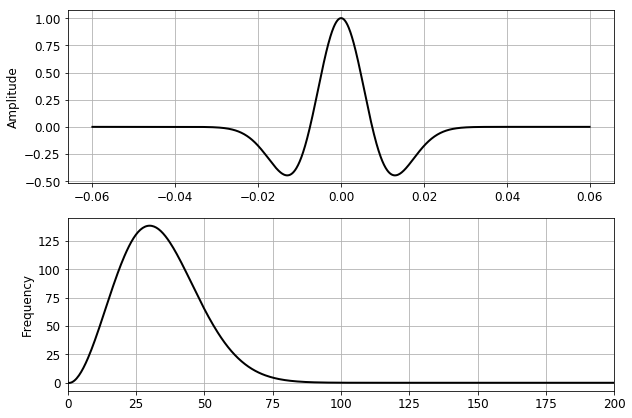

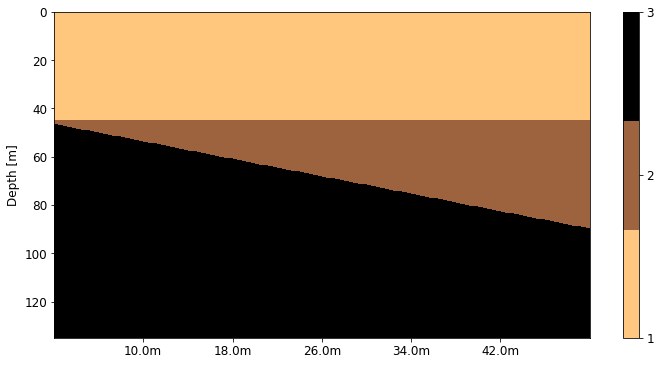

In [28]:
plot_wavelet_spectrum(wavl,time,srt)
rock_grid=make_wedge(n_traces,layer_1_thickness,min_thickness,max_thickness,srz)
plot_rock_grid(rock_grid,srz), plt.ylabel('Depth [m]')
update_xlabels(min_thickness,max_thickness,n_traces)

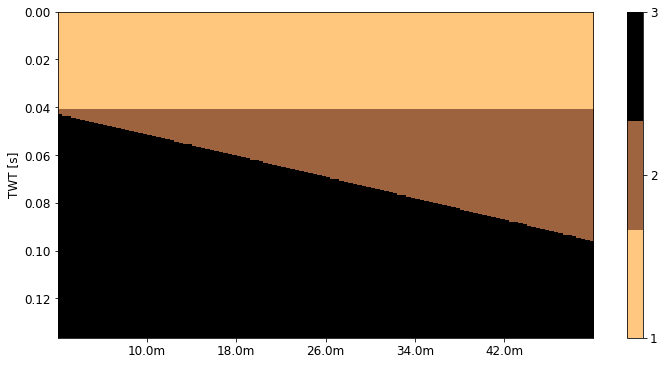

In [29]:
vels = assign_vel(rock_grid, acprop)
rock_grid_twt=depth_to_time(rock_grid,vels,srz,srt,twt=True)
plot_rock_grid(rock_grid_twt,srt), plt.ylabel('TWT [s]')
update_xlabels(min_thickness,max_thickness,n_traces)
model=assign_ai(rock_grid_twt,acprop)
rc = make_rc(model)

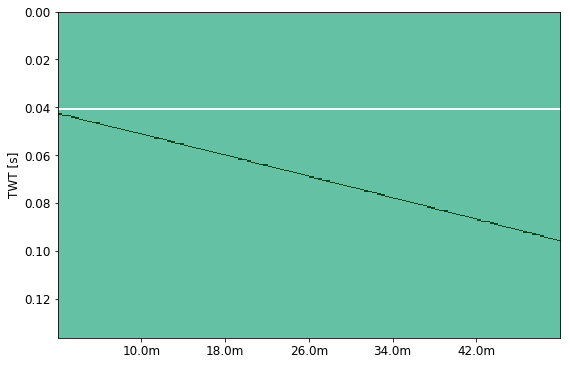

In [30]:
plot_rc(rc, srt)
plt.ylabel('TWT [s]')
update_xlabels(min_thickness,max_thickness,n_traces)

(None, Text(0, 0.5, 'TWT [ms]'), Text(0.5, 0, 'Traces'))

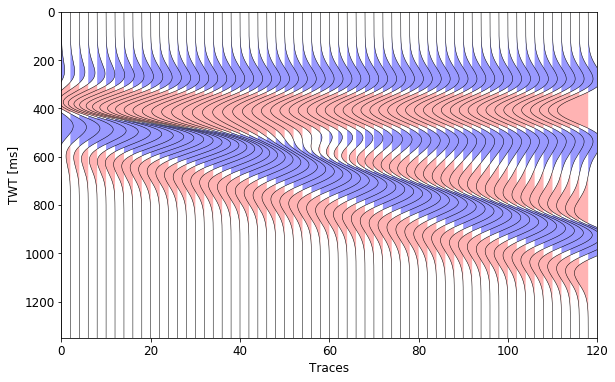

In [32]:
[ns,nt]=rock_grid_twt.shape
incr=(max_thickness-min_thickness)/float(nt)

seismic=make_synth(rc,wavl)
#plot_density(seismic,srt), plt.ylabel('TWT[s]') 
plot_wiggle(seismic,srt,skip=2,gain=10), plt.ylabel('TWT [ms]'), plt.xlabel('Traces')
#plot_wiggle(seismic,srt,skip=2,gain=10,black=True), plt.ylabel('TWT [ms]'), plt.xlabel('Traces')

In [33]:
seis=forward_model(model=rock_grid,aiprop=acprop,wavelet=wavl,dz=srz,dt=srt)
gain=3
skip=1
[ns,nt]=seis.shape
twt=np.arange(0,ns*srt,srt)
amp0,ff0=ampspec(seis[:,0],srt)
spectra=np.zeros((amp0.size,nt))

Text(0, 0.5, 'Frequency [Hz]')

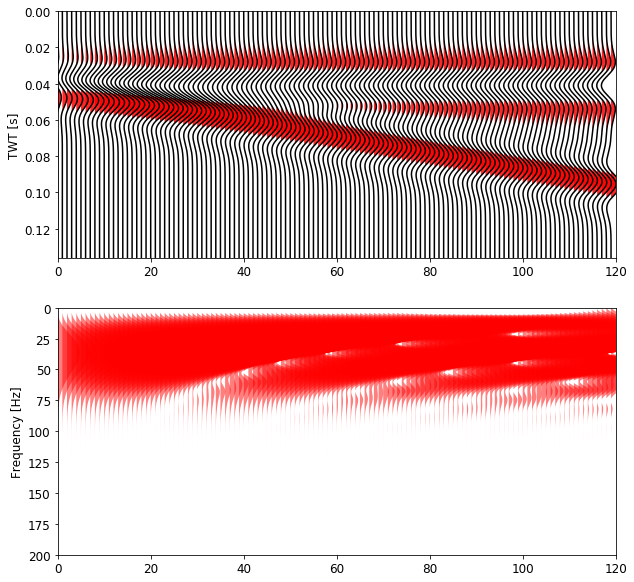

In [34]:
for i in range(nt):
    amp,ff=ampspec(seis[:,i],srt)
    spectra[:,i]=amp

f, ax = plt.subplots(2,figsize=(10,10))
for i in range(0,nt,skip):
    trace=seis[:,i]/np.max(np.abs(seis))*gain
    spect=spectra[:,i]/gain
    ax[0].plot(i+trace,twt,color='k')
    ax[0].fill_betweenx(twt,i+trace,i,where=i+trace>i,facecolor='r',lw=0,alpha=0.85)
    ax[1].fill_betweenx(ff,i+spect,i,where=i+spect>i,facecolor='r',lw=5,alpha=0.5,cmap='rainbow')
for aa in ax.flatten():
    aa.set_xlim(0,nt)
ax[0].set_ylim(max(twt),min(twt))
ax[0].set_ylabel('TWT [s]')
ax[1].set_ylim(200,0)
ax[1].set_ylabel('Frequency [Hz]')

Text(0.5, 0, 'Thickness [m]')

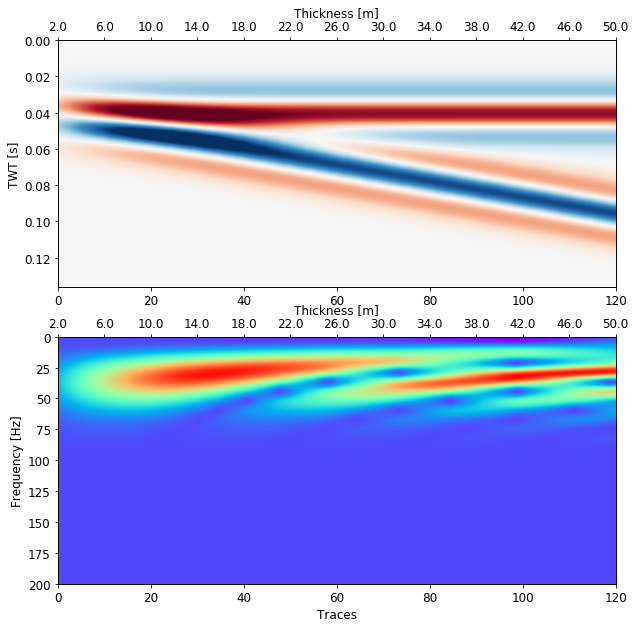

In [36]:
#plot_density(seis,srt), plt.ylabel('TWT[s]')
#sd=spectraldecomp(seis, f=(10,20,30,40),window_length=0.030,dt=srt)
clip=abs(np.percentile(seis, 0.999))
f, ax = plt.subplots(2,figsize=(10,10))
im0=ax[0].imshow(seis,extent=[0,seis.shape[1],seis.shape[0]*srt,0],interpolation='bilinear',aspect='auto',cmap='RdBu',vmin=-clip,vmax=clip)
im1=ax[1].imshow(spectra,extent=[0,spectra.shape[1],ff.max(),0],interpolation='bilinear',aspect='auto',cmap='rainbow')
ax[0].set_ylabel('TWT [s]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_ylim(200,0),ax[1].set_xlabel('Traces')

ax2 = ax[1].twiny()
ax2.set_xticks(range(0,nt+1,10))
ax2.set_xticklabels(np.arange(0,nt+1,10)*incr+min_thickness)
ax2.set_xlabel('Thickness [m]')

ax2 = ax[0].twiny()
ax2.set_xticks(range(0,nt+1,10))
ax2.set_xticklabels(np.arange(0,nt+1,10)*incr+min_thickness)
ax2.set_xlabel('Thickness [m]')

In [37]:
#Extract individual traces

thickness=np.array([20,22,30])                              #Traces to be highlighted
thickness-=min_thickness

[ns,nt]=seis.shape
twt=np.arange(0,ns*srt,srt)

thickness_traces=np.floor(thickness/incr)                   #Trace corresponding to the highlighted values

tuning_thick = np.argmax(np.abs(seis)) % seis.shape[1]      #Tuning thickness
tuning_thickness=tuning_thick-min_thickness
tuning_trace=np.floor(tuning_thickness/incr)                #Trace corresponding to tuning thickness

tt=np.zeros((seis.shape[0],thickness.size))

Text(0.5, 0, 'Thickness [m]')

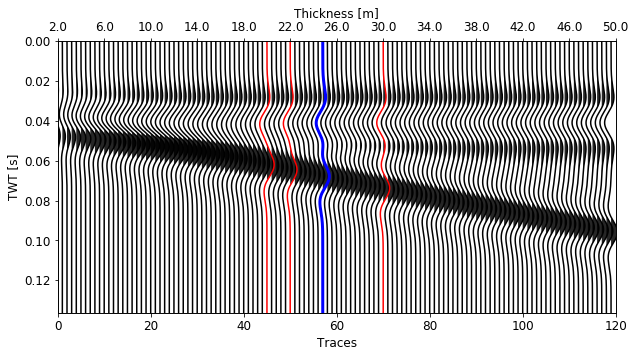

In [42]:
for i,val in enumerate(thickness_traces):
    tt[:,i]=seis[:,int(val)]

# wiggle plot of the seismic with highlighted traces in red
fig, ax1 = plt.subplots(figsize=(10,5))
# plt.figure(figsize=(12,6))

for i in range(0,nt):
    trace=seis[:,i]/np.max(np.abs(seis))*2
    if i == tuning_trace:
        ax1.plot(i+trace,twt,color='b',lw=3)                    #Blue color to tuning thickness trace
    elif i in thickness_traces:
        ax1.plot(i+trace,twt,color='r',lw=1.5)                  #Red color to the highlighted traces
    else:
        ax1.plot(i+trace,twt,color='k')
    ax1.fill_betweenx(twt,trace+i,i,where=trace+i>i,facecolor='k',lw=0,alpha=0.85)
    
ax1.set_xlim(0,nt)
ax1.set_ylim(min(twt),max(twt))
ax1.invert_yaxis()
ax1.set_xlabel('Traces')
ax1.set_ylabel('TWT [s]')

ax2 = ax1.twiny()
ax2.set_xticks(range(0,nt+1,10))
ax2.set_xticklabels(np.arange(0,nt+1,10)*incr+min_thickness)
ax2.set_xlabel('Thickness [m]')


The tuning thickness of the wedge is: 25.00 m


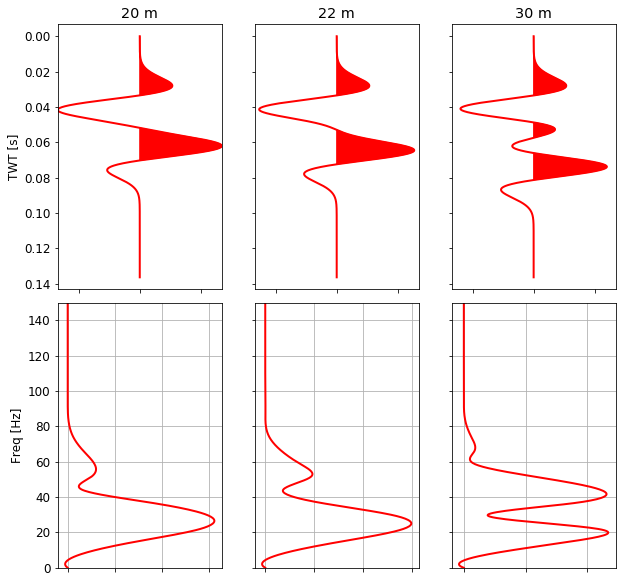

In [44]:
tit_thick=thickness+min_thickness                                       #Title for extracted traces
    
f, ax = plt.subplots(nrows=2,ncols=3,figsize=(10,10))
for i in range(0,3):
    ufft,ufreq=ampspec(tt[:,i],srt)
    ax[0,i].plot(tt[:,i],twt,color='r',lw=2)                            #Extract trace
    ax[0,i].fill_betweenx(twt,tt[:,i],0,tt[:,i]>0.0, color='r')
    ax[1,i].plot(ufft,ufreq,color='r',lw=2)                             #Frequency spectra
    ax[0,i].set_title('%d m' % tit_thick[i])
    ax[0,i].set_xlim(np.min(tt),np.max(tt))
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[0,i].get_yticklabels(), visible=False)
    ax[1,i].set_ylim(150,0)
    # ax[1,i].set_xlim(-0.1,1.1)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_yticklabels(), visible=False)
    ax[1,i].grid()
ax[0,0].set_ylabel('TWT [s]')
ax[1,0].set_ylabel('Freq [Hz]')
plt.setp(ax[0,0].get_yticklabels(), visible=True)
plt.setp(ax[1,0].get_yticklabels(), visible=True)

for aa in ax.flatten():
    aa.invert_yaxis()
f.subplots_adjust(hspace=0.05)
print('The tuning thickness of the wedge is: %.2f m' % (tuning_thick))

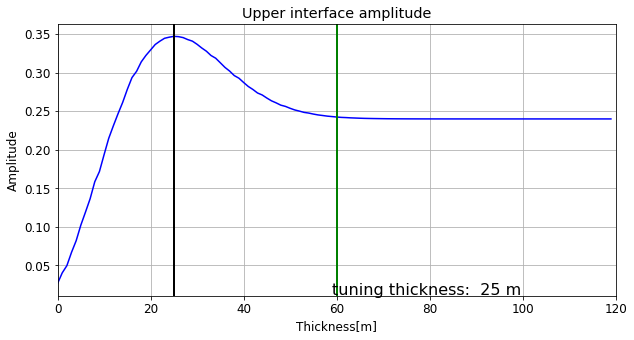

In [45]:
#Plot amplitude spectrum
plt.figure(figsize=(10,5))
aa=np.argmax(abs(seis[:,-1]))                                   #trace no of first interface
plt.plot(abs(seis[aa,:]), color='blue')                         #plot amplitude of upper interface
plt.xlim(0,120)
plt.axvline(x=tuning_thick,lw=2, color='k')                     #vertical line corresponding to tuning thickness
plt.axvline(x=60,lw=2, color='g')                               #vertical line corresponding to onset of constructive interference
plt.text(tuning_trace + 2, plt.ylim()[0] * 1.1,
        'tuning thickness:  {0} m'.format(str(tuning_thick)),
        fontsize=16)
plt.title('Upper interface amplitude')
plt.xlabel('Thickness[m]')
plt.ylabel('Amplitude')
plt.grid()
